# Vehicle Detection Project

#### Import Needed Libraries

In [121]:
import math
import os
import pickle
import glob
import random
import time

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

% matplotlib inline

# RESEARCH SEGMENT [ FINAL CODE SEGMENT BELOW ⇓ ]

#### Read Data Files, Visualize Data Samples

Image Shape (64, 64, 3)


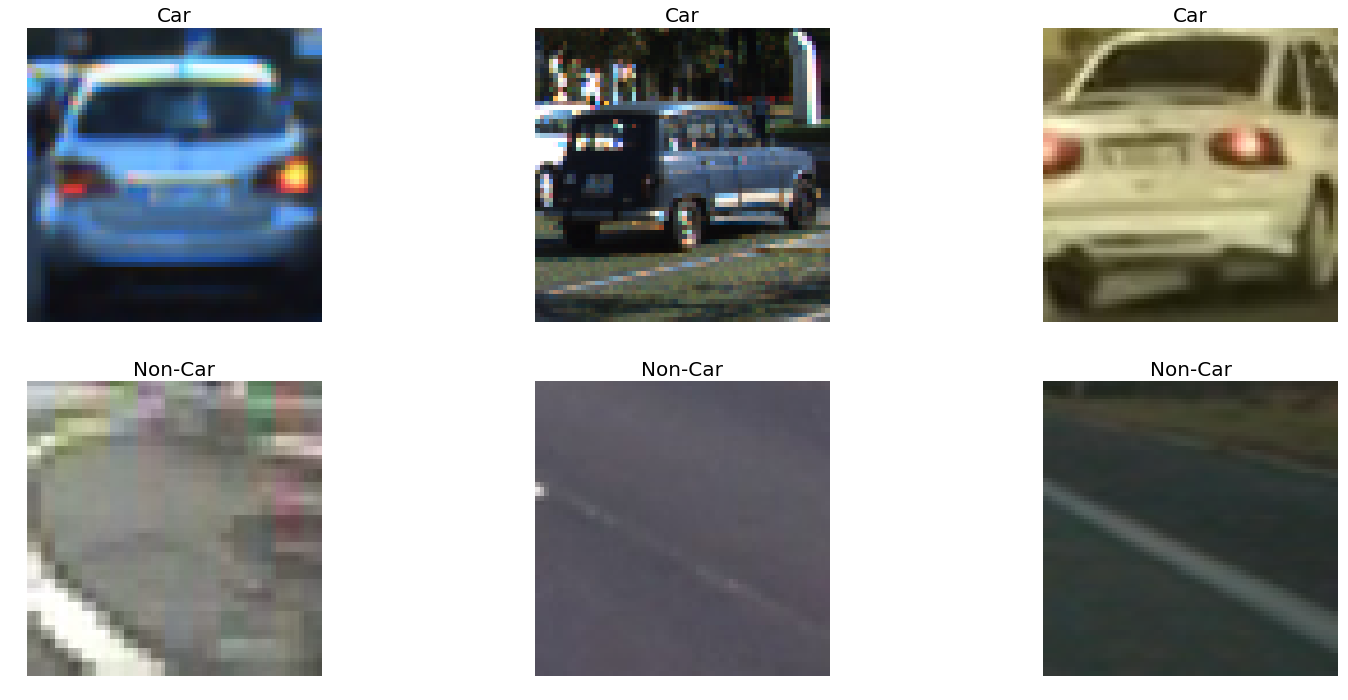

In [66]:
#Use glob to read data file meta-data as bulk fetch
car_meta = glob.glob('train_images/vehicles/*/*.png')
noncar_meta = glob.glob('train_images/non-vehicles/*/*.png')

#cars & non-cars collection
cars = []
noncars = []
for fname in car_meta:
    cars.append(fname)
    
for fname in noncar_meta:
    noncars.append(fname)

#Render random Samples
fig, axes = plt.subplots(2, 3, figsize=(10,10))

axes[0,0].imshow(mpimg.imread(cars[random.randrange(0, len(cars))]))
axes[0,0].set_title('Car', fontsize=20)
axes[0,0].axis('off')

axes[0,1].imshow(mpimg.imread(cars[random.randrange(0, len(cars))]))
axes[0,1].set_title('Car', fontsize=20)
axes[0,1].axis('off')

axes[0,2].imshow(mpimg.imread(cars[random.randrange(0, len(cars))]))
axes[0,2].set_title('Car', fontsize=20)
axes[0,2].axis('off')

axes[1,0].imshow(mpimg.imread(noncars[random.randrange(0, len(noncars))]))
axes[1,0].set_title('Non-Car', fontsize=20)
axes[1,0].axis('off')

axes[1,1].imshow(mpimg.imread(noncars[random.randrange(0, len(noncars))]))
axes[1,1].set_title('Non-Car', fontsize=20)
axes[1,1].axis('off')

axes[1,2].imshow(mpimg.imread(noncars[random.randrange(0, len(noncars))]))
axes[1,2].set_title('Non-Car', fontsize=20)
axes[1,2].axis('off')

plt.subplots_adjust(left=0., right=2, top=0.9, bottom=0.)

print ("Image Shape", mpimg.imread(cars[random.randrange(0, len(cars))]).shape)

### Helper Functions For Research Purposes

1. Spatial Bin
2. Color Histograms
3. HOG (Histograms Of Directional/Oriented Gradient)
4. Feature Extract (Combined)
5. Normalization
6. Sliding Window
7. Train Classifer (SVM - Linear Support Vector Machine)
8. Heat Maps
9. Vehicle Detection Pipeline

In [175]:
# Spatial Binning is smart way to reduce overall pixels without compromising features from the image.
# Input - Raw Image, Bin Size   Output- Feature Vector
def spatial_bin(image, size):
    rd_img=cv2.resize(image, size)
    features = rd_img.ravel() # Use OpenCV ravel() to create the feature vector
    
    return rd_img, features

# Color Histogram is interesting way to extract pixel intensities as features 
# Inputs: Raw Image, Bin Count, Channel Range (Varies for .png, .jpg & choice of OpenCV, Matplotlib)
# Outputs: Channel Wise Histogram, Bin (Edges, Center), Blended Features
def color_hist(image, bins, ch_range):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(image[:, :, 0], bins=bins, range=ch_range)
    channel2_hist = np.histogram(image[:, :, 1], bins=bins, range=ch_range)
    channel3_hist = np.histogram(image[:, :, 2], bins=bins, range=ch_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    return channel1_hist,channel2_hist,channel2_hist,bin_edges,bin_centers,hist_features

# Histogram of Oriented/Directional Gradients : skimage.hog()
# Input: Raw Image, Orientation, Pixels Per cell, Cells Per Block, (Visualization, Feture Vector - True/False)
# Output: features, hog_image
def hog_features(image, orient, pix_per_cell, cell_per_block,
                     visualization=False, feature_vec=True):
    # Return features with hog image
    if visualization:
        features, hog_image = hog(image, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=visualization, feature_vector=feature_vec)
        return features, hog_image
    # Return only features
    else:
        features = hog(image, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=visualization, feature_vector=feature_vec)
        return features
    
# Helper Function to Derive Combined Features using Spatial, Color, HOG
# Input: Image Array, Color Space, Spatial Bin Size, Histogram Bins, Orient, 
#        Pixels Per Cell, Cell Per Block, Hog Channels, Spatial Enabled, Hist Enabled, HOG Enabled
# Outout: Combined Features
def extract_features(images, color_space, spatial_size,
                     hist_bins, ch_range, orient,
                     pix_per_cell, cell_per_block,
                     hog_channel, visualization, feature_vec,
                     spatial_enabled, hist_enabled, 
                     hog_enabled):
    
    # Create a placeholder list for feature vectors
    features = []
    
    # Loop through Images
    for img in images:
        image_features = []
        # Read in each one by one
        image = cv2.imread(img)
        
        # Apply Requested Color Space
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_enabled:
            rd_img, spatial_features = spatial_bin(feature_image, size=spatial_size)
            image_features.append(spatial_features)
        if hist_enabled:
            channel1_hist,channel2_hist,channel2_hist,bin_edges,bin_centers,hist_features = color_hist(feature_image, bins=hist_bins, ch_range=ch_range )
            image_features.append(hist_features)
        if hog_enabled:
            if hog_channel == 'ALL':
                hog_feature = []
                for channel in range(feature_image.shape[2]):
                    if visualization:
                        hog_ft, hog_img = hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         visualization, feature_vec)
                        hog_feature.append(hog_ft)
                    else:
                        hog_ft=hog_features(feature_image[:, :, channel],orient,pix_per_cell,cell_per_block,visualization,feature_vec)
                        hog_feature.append(hog_ft)
                hog_feature = np.ravel(hog_feature)
            else:
                if visualization:
                    hog_feature, hog_img = hog_features(feature_image[:, :, hog_channel],
                                                         orient,pix_per_cell, 
                                                         cell_per_block, 
                                                         visualization, 
                                                         feature_vec)
                else:
                    hog_feature = hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, 
                                                visualization, feature_vec)
            
            # Append the new feature vector to the features list
            image_features.append(hog_feature)
        
        features.append(np.concatenate(image_features))
    
    # Return combined feature vectors
    return features

#Test Draw Boxes 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space, spatial_size,
                     hist_bins, orient,
                     pix_per_cell, cell_per_block,
                     hog_channel, spatial_enabled, 
                     hist_enabled, 
                     hog_enabled):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_enabled == True:
        rd_img, spatial_features = spatial_bin(feature_image, spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_enabled == True:
        col_hist1,col_hist2,col_hist3,bin_ed,bin_cn,hist_features = color_hist(feature_image, hist_bins, (0,256))
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_enabled == True:
        if hog_channel == 'ALL':
            hog_feature = []
            for channel in range(feature_image.shape[2]):
                hog_feature.extend(hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     False, True))
        else:
            hog_feature = hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, False, True)
        # 8) Append features to list
        img_features.append(hog_feature)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space,
                   spatial_size, hist_bins,
                   ch_range, orient,
                   pix_per_cell, cell_per_block,
                   hog_channel, spatial_enabled,
                   hist_enabled, hog_enabled):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    #Sprint("Akki5")
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        #temp_image = np.array([test_img])
        print("Akki6")
        features = single_img_features(test_img, "LUV",
                                       (64,64), 64,
                                       18, 8,
                                       2,
                                       "ALL", True,
                                       False, True)
        print("Akki7", np.isnan(features).any())
        #features[np.isnan(features)] = np.median(features[~np.isnan(features)])
        #print("Akki7", np.isnan(features).any())
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        print("Akki8")
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        #print("Akki9")
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    # 8) Return windows for positive detections
    return on_windows

# Sliding Window Routine, given Image, Area of Interest and Overlap Ration
# Routine produces number of ideal windows & their coordinates as collection output
def sliding_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5),window_list=None):
    
    #print("Akki", x_start_stop, y_start_stop, x_start_stop[0], x_start_stop[1], y_start_stop[0], y_start_stop[1], xy_window)
    # If x and/or y start/stop positions not defined, set default to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    x_s_s = [x_start_stop[0], y_start_stop[0]]
    y_s_s = [x_start_stop[1], y_start_stop[1]]
    
    x_start_stop = x_s_s
    y_start_stop = y_s_s
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    #print("Akki1", xspan, yspan)
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    #print("Akki2", nx_pix_per_step, nx_pix_per_step)
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    #print("Akki3", nx_windows, ny_windows)
    
    # Initialize a list to append window positions to
    if window_list == None:
        window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

## Test Helper Functions

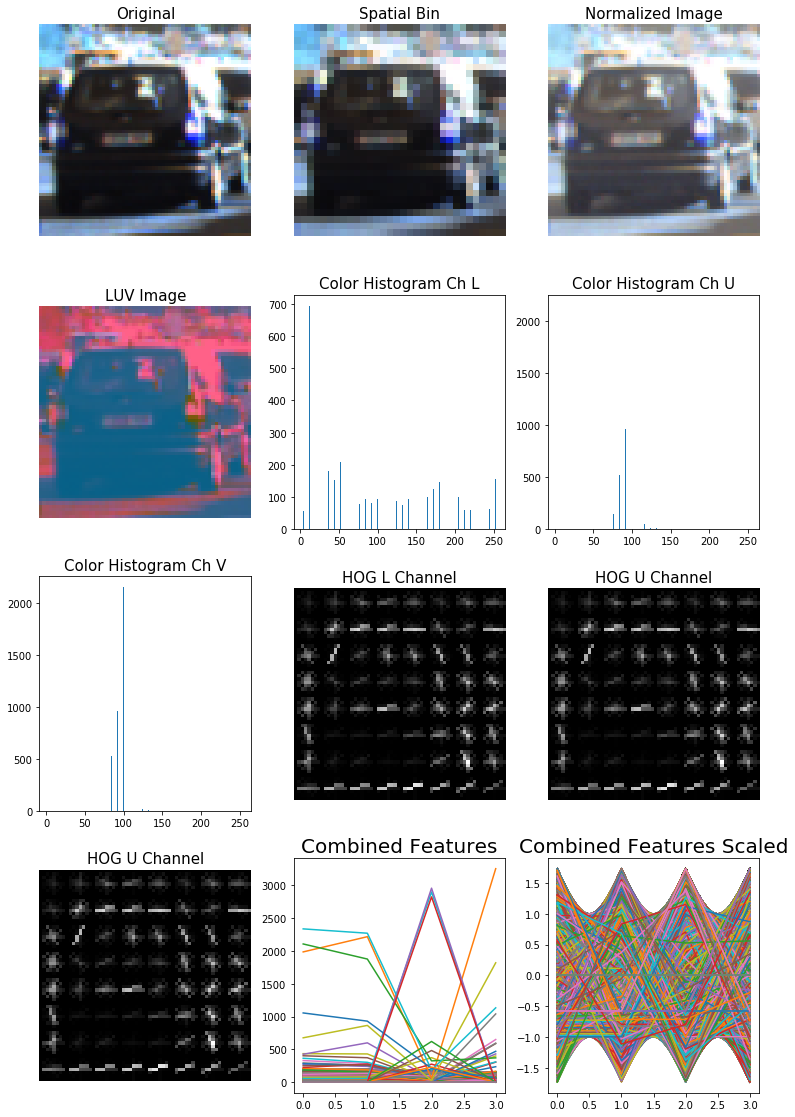

In [105]:
#Sample Image
sample_img = cv2.imread(cars[random.randrange(0, len(cars))])
normalized_img = (np.sqrt(sample_img.astype(np.float32)/255)*255).astype(np.uint8)

#Derive Spatial Bin
rd_img, features = spatial_bin(sample_img, (32,32))

#Derive Color Histogram
luv_img  = cv2.cvtColor(sample_img, cv2.COLOR_RGB2LUV)
col_hist1,col_hist2,col_hist3,bin_ed,bin_cn,features = color_hist(luv_img, 32, (0,256))

#Derive HOG
features_hg, hog_img_l = hog_features(luv_img[:,:,0], 18,8,2,visualization=True)
features_hg,hog_img_u = hog_features(luv_img[:,:,0], 18,8,2,visualization=True)
features_hg,hog_img_v = hog_features(luv_img[:,:,0], 18,8,2,visualization=True)

#Derive Combined Features
car_features = extract_features(cars[:2], "LUV", (64,64),
                     32, (0,256), 18,
                     8, 2,
                     "ALL", False, True,
                     True, True, 
                     True)

noncar_features = extract_features(noncars[:2], "LUV", (64,64),
                     32, (0,256), 18,
                     8, 2,
                     "ALL", False, True,
                     True, True, 
                     True)

combined_features = np.vstack((car_features, noncar_features)).astype(np.float64)                        
ft_scaler = StandardScaler().fit(combined_features)
combined_features_scaled = ft_scaler.transform(combined_features)

##Render Test Samples
fig, axes = plt.subplots(4, 3, figsize=(10,10))

axes[0,0].imshow(sample_img)
axes[0,0].set_title('Original', fontsize=15)
axes[0,0].axis('off')

axes[0,1].imshow(rd_img)
axes[0,1].set_title('Spatial Bin', fontsize=15)
axes[0,1].axis('off')

axes[0,2].imshow(normalized_img)
axes[0,2].set_title('Normalized Image', fontsize=15)
axes[0,2].axis('off')

axes[1,0].imshow(luv_img)
axes[1,0].set_title('LUV Image', fontsize=15)
axes[1,0].axis('off')

axes[1,1].bar(bin_cn,col_hist1[0])
axes[1,1].set_title('Color Histogram Ch L', fontsize=15)

axes[1,2].bar(bin_cn,col_hist2[0])
axes[1,2].set_title('Color Histogram Ch U', fontsize=15)

axes[2,0].bar(bin_cn,col_hist3[0])
axes[2,0].set_title('Color Histogram Ch V', fontsize=15)

axes[2,1].imshow(hog_img_l, cmap='gray')
axes[2,1].set_title('HOG L Channel', fontsize=15)
axes[2,1].axis('off')

axes[2,2].imshow(hog_img_u, cmap='gray')
axes[2,2].set_title('HOG U Channel', fontsize=15)
axes[2,2].axis('off')

axes[3,0].imshow(hog_img_v, cmap='gray')
axes[3,0].set_title('HOG U Channel', fontsize=15)
axes[3,0].axis('off')

axes[3,1].plot(combined_features[:100])
axes[3,1].set_title('Combined Features', fontsize=20)

axes[3,2].plot(combined_features_scaled[:100])
axes[3,2].set_title('Combined Features Scaled', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=2, bottom=.5)


******* Test Sliding Window *********


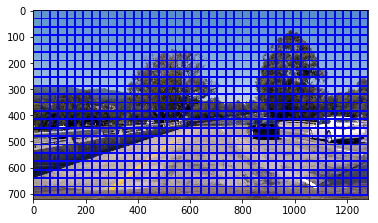

In [125]:
print("******* Test Sliding Window *********")
X_scaler = pickle.load(open("features.p", "rb"))
svm = joblib.load("svm_model.p")

#Temporary Test, Draw Boxes
image = mpimg.imread('test_images/test1.jpg')

bboxes = sliding_window(image)
mod_img = draw_boxes(image, bboxes)

plt.imshow(mod_img)

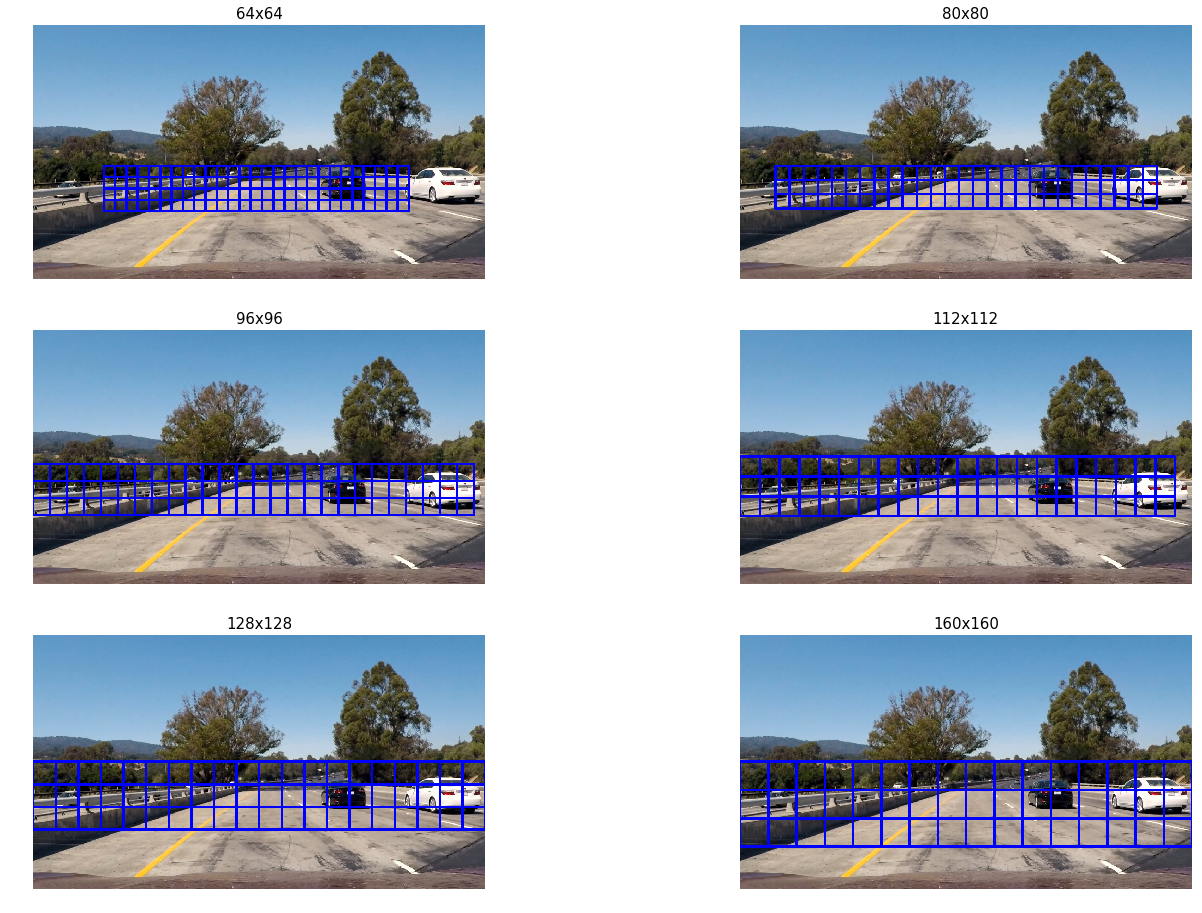

In [185]:
#Search Window Dimensions
window_size=[64, 80, 96, 112, 128, 160]#, 192, 224, 256]
window_roi=[[[200, 400],[1080, 550]], [[100, 400],[1180, 550]], [[0, 380],[1280, 550]],
                [[0, 360],[1280, 550]], [[0, 360],[1280, 600]], [[0, 360],[1280, 670] ]]#,
i=0
for size, roi in zip(window_size, window_roi):
    #print (size, roi[0], roi[1])
    bboxes = sliding_window(img, x_start_stop=roi[0], y_start_stop=roi[1],
                 xy_window=(size, size), xy_overlap=(0.5, 0.5),window_list=None)
    mod_img = draw_boxes(image, bboxes)
    title = str(size)+'x'+str(size)
    i+=1
    plt.subplot(3, 2, i)
    plt.imshow(mod_img)
    plt.title(title, fontsize=15)
    plt.axis('off')
plt.subplots_adjust(left=0., right=3, top=3, bottom=0.)





# Start afresh with clean code for Vehicle Detection

In [1]:
# File to store Classifier and Scalar
CALIB_FILE_NAME = "calib.p"

ORIGINAL_SIZE = 1280, 720
#UNWARPED_SIZE = 500, 600

In [126]:
#Class to help with Filtered Box
class DigitalFilter:

    def __init__(self, vector, b, a):
        self.len = len(vector)
        self.b = b.reshape(-1, 1)
        self.a = a.reshape(-1, 1)
        self.input_history = np.tile(vector.astype(np.float64), (len(self.b), 1))
        self.output_history = np.tile(vector.astype(np.float64), (len(self.a), 1))
        self.old_output = np.copy(self.output_history[0])

    def output(self):
        return self.output_history[0]

    def new_point(self, vector):
        self.input_history = np.roll(self.input_history, 1, axis=0)
        self.old_output = np.copy(self.output_history[0])
        self.output_history = np.roll(self.output_history, 1, axis=0)
        self.input_history[0] = vector
        self.output_history[0] = (np.matmul(self.b.T, self.input_history) - np.matmul(self.a[1:].T, self.output_history[1:]))/self.a[0]
        return self.output()

    def skip_one(self):
        self.new_point(self.output())

In [4]:
def area(bbox):
    return float((bbox[3] - bbox[1]) * (bbox[2] - bbox[0]))

In [20]:
# Class holding instance of Car
class Car:
    def __init__(self, bounding_box, first=False):

        self.filtered_bbox = DigitalFilter(bounding_box, 1/21*np.ones(21, dtype=np.float32), np.array([1.0, 0]))
        self.found = True
        self.num_lost = 0
        self.num_found = 0
        self.display = first
        self.fps = 25

    def get_window(self):
        return self.filtered_bbox.output()

    def one_found(self):
        self.num_lost = 0
        if not self.display:
            self.num_found += 1
            if self.num_found > 5:
                self.display = True

    def one_lost(self):
        self.num_found = 0
        self.num_lost += 1
        if self.num_lost > 5:
            self.found = False

    def update_car(self, bboxes):
        current_window = self.filtered_bbox.output()
        intersection = np.zeros(4, dtype = np.float32)
        for idx, bbox in enumerate(bboxes):
            intersection[0:2] = np.maximum(current_window[0:2], bbox[0:2])
            intersection[2:4] = np.minimum(current_window[2:4], bbox[2:4])
            if (area(bbox)>0) and area(current_window) and ((area(intersection)/area(current_window)>0.8) or (area(intersection)/area(bbox)>0.8)):
                self.one_found()
                self.filtered_bbox.new_point(bbox)
                bboxes.pop(idx)
                return

        self.one_lost()
        self.filtered_bbox.skip_one()

    def draw(self, img, color=(0, 255, 0), thickness=2):
        if self.display:
            window = self.filtered_bbox.output().astype(np.int32)
            cv2.rectangle(img, (window[0], window[1]), (window[2], window[3]), color, thickness)

In [53]:
#Vehicle Finder Class with helper functions
class CarFinder:
    def __init__(self, size, hist_bins, small_size, orientations=12, pix_per_cell=8, cell_per_block=2,
                 hist_range=None, scaler=None, classifier=None, window_sizes=None, window_rois=None):
        self.size = size
        self.small_size = small_size
        self.hist_bins = hist_bins
        self.hist_range = (0, 256)
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.orientations = orientations
        self.scaler = scaler
        self.cls = classifier
        self.num_cells = self.size//self.pix_per_cell
        self.num_blocks = self.num_cells - (self.cell_per_block-1)
        self.num_features = self.calc_num_features()
        if hist_range is not None:
            self.hist_range = hist_range

        self.window_sizes = window_sizes
        self.window_rois = window_rois
        self.cars = []
        self.first = True
        
    def calc_num_features(self):
        return self.small_size**2*3 + self.hist_bins*3 + 3*self.num_blocks**2 *self.cell_per_block**2*self.orientations

    def get_features(self, img):
        img_resize = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        img_resize = (np.sqrt(img_resize.astype(np.float32)/255)*255).astype(np.uint8)
        img_LUV = cv2.cvtColor(img_resize, cv2.COLOR_RGB2LUV)
        img_feature = cv2.resize(img_LUV, (self.small_size, self.small_size), interpolation=cv2.INTER_LINEAR)
        hist_l = np.histogram(img_LUV[:, :, 0], bins=self.hist_bins, range=self.hist_range)
        width = 0.7 * (hist_l[1][1] - hist_l[1][0])
        center = (hist_l[1][:-1] + hist_l[1][1:]) / 2
        hist_u = np.histogram(img_LUV[:, :, 1], bins=self.hist_bins, range=self.hist_range)
        hist_v = np.histogram(img_LUV[:, :, 2], bins=self.hist_bins, range=self.hist_range)
        features_l = hog(img_LUV[:, :, 0], self.orientations, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block,  self.cell_per_block), transform_sqrt=False,
                       feature_vector=True)
        features_u = hog(img_LUV[:, :, 1], self.orientations, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block,  self.cell_per_block), transform_sqrt=False,
                       feature_vector=True)
        features_v = hog(img_LUV[:, :, 2], self.orientations, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                       cells_per_block=(self.cell_per_block,  self.cell_per_block), transform_sqrt=False,
                       feature_vector=True)
        return np.hstack((img_feature.ravel(), hist_l[0], hist_u[0], hist_v[0], features_l, features_u, features_v))

    def car_find_roi(self, img, size, roi, overlap):
        #print ("AAAA", size, roi, overlap)
        assert self.scaler is not None, "CarFinder error -> Scaler has to be initialized"
        assert self.cls is not None, "CarFinder error -> Classifier has to be initialized"
        width = roi[1][0]-roi[0][0]
        height = roi[1][1]-roi[0][1]
        img_roi = img[roi[0][1]:roi[1][1], roi[0][0]:roi[1][0]]
        scale = float(size)/self.size
        new_width = int(math.ceil(float(width)/scale))
        new_height = int(math.ceil(float(height)/scale))
        
        #print ("AAAA1", width, height, img_roi, scale, new_width, new_height)
        
        img_roi = cv2.resize(img_roi, (new_width, new_height))
        img_roi = (np.sqrt(img_roi.astype(np.float32)/255)*255).astype(np.uint8)
        img_roi = cv2.cvtColor(img_roi, cv2.COLOR_RGB2LUV)
        img_small = cv2.resize(img_roi, (math.ceil(new_width*self.small_size/float(self.size)),
                                         math.ceil(new_height*self.small_size/float(self.size))))
        img_hog_l = hog(img_roi[:, :, 0], self.orientations, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                      cells_per_block=(self.cell_per_block,  self.cell_per_block), transform_sqrt=False,
                      feature_vector=False)
        img_hog_u = hog(img_roi[:, :, 1], self.orientations, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                      cells_per_block=(self.cell_per_block,  self.cell_per_block), transform_sqrt=False,
                      feature_vector=False)
        img_hog_v = hog(img_roi[:, :, 2], self.orientations, pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                      cells_per_block=(self.cell_per_block,  self.cell_per_block), transform_sqrt=False,
                      feature_vector=False)
        shift_roi = int((1-overlap)*self.size)
        shift_small = int((1-overlap)*self.small_size)
        shift_hog = int((1-overlap)*(self.size//self.pix_per_cell))
        n_horizontal = int((new_width-self.size)/shift_roi) + 1
        n_vertical = int((new_height-self.size)/shift_roi) + 1
        total_windows = n_horizontal*n_vertical
        
        #print ("AAAA2", shift_roi, shift_small, shift_hog, n_horizontal, n_vertical, total_windows)
        
        all_features = np.zeros((total_windows, self.num_features), dtype = np.float32)
        all_coordinates = np.zeros((total_windows, 4), dtype=np.int32)

        current = 0
        for col in range(n_horizontal):
            for row in range(n_vertical):
                img_ = img_roi[row*shift_roi:row*shift_roi+self.size, col*shift_roi:col*shift_roi+self.size]
                hist_h = np.histogram(img_[:, :, 0], bins=self.hist_bins, range=self.hist_range)
                hist_l = np.histogram(img_[:, :, 1], bins=self.hist_bins, range=self.hist_range)
                hist_s = np.histogram(img_[:, :, 2], bins=self.hist_bins, range=self.hist_range)
                all_features[current] = np.hstack((img_small[row*shift_small:row*shift_small+self.small_size,
                                                   col*shift_small:col*shift_small+self.small_size].ravel(),
                                                   hist_h[0], hist_l[0], hist_s[0],
                                                   img_hog_l[row*shift_hog:row*shift_hog+self.num_cells,
                                                   col*shift_hog:col*shift_hog+self.num_cells].ravel(),
                                                   img_hog_u[row*shift_hog:row*shift_hog+self.num_cells,
                                                   col*shift_hog:col*shift_hog+self.num_cells].ravel(),
                                                   img_hog_v[row*shift_hog:row*shift_hog+self.num_cells,
                                                   col*shift_hog:col*shift_hog+self.num_cells].ravel()
                                                   ))
                all_coordinates[current][0] = roi[0][0] + int(scale*col*shift_roi)
                all_coordinates[current][1] = roi[0][1] + int(scale*row*shift_roi)
                current += 1

        all_coordinates[:, 2:4] = size + all_coordinates[:, 0:2]
        #print ("AAAA3",all_coordinates.tolist())
        cars = self.cls.predict(self.scaler.transform(all_features))
        return all_coordinates[cars == 1].tolist()

    def find_cars(self, img, threshold = 1, reset = False):
        heatmap = np.zeros_like(img[:,:,1])
        car_windows = []
        if reset:
            self.cars = []
            self.first = True
        for size, roi in zip(self.window_sizes, self.window_rois):
            car_windows += self.car_find_roi(img, size, roi, overlap=0.75)
        
        for car in self.cars:
            window = car.get_window()
            heatmap[window[1]:window[3],window[0]:window[2]] += 1

        for window in car_windows:
            heatmap[window[1]:window[3],window[0]:window[2]] += 1

        heatmap = heatmap > threshold
        label_img, labels = label(heatmap)
        bboxes = []
        for lbl in range(labels):
            points = (label_img == lbl+1).nonzero()
            nonzeroy = np.array(points[0])
            nonzerox = np.array(points[1])
            bbox = np.array((np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)))
            car_img = img[bbox[1]:bbox[3],bbox[0]:bbox[2], :]
            he = bbox[3]-bbox[1]
            medi = np.median(car_img[-he//8:-1], axis=[0,1])
            near = cv2.inRange(car_img, medi - np.array([35, 35, 35]),medi+np.array([35, 35, 35]))
            if near is not None:
                cc = np.sum(near, axis=1)/255 > int(0.8*near.shape[1])
                eee = len(cc)-1
                while eee >= 0 and cc[eee]:
                    eee -= 1
                bbox[3] = bbox[1]+eee
            bboxes.append(bbox)

        for car in self.cars:
            car.update_car(bboxes)

        for bbox in bboxes:
            self.cars.append(Car(bbox, self.first))

        tmp_cars = []
        for car in self.cars:
            if car.found:
                tmp_cars.append(car)
        self.cars = tmp_cars
        self.first = False

    def draw_cars(self, img):
        i2 = np.copy(img)
        for car in self.cars:
            car.draw(i2)
        return i2

# Training SVM

In [123]:
vehicle_dir = "train_images/vehicles"
non_vehicle_dir = "train_images/non-vehicles"
total_imgs = 0

spatial_size = (64, 64)
n_bins = 128
hist_range = (0, 255)

car_finder = CarFinder(64, hist_bins=128, small_size=20, orientations=12, pix_per_cell=8, cell_per_block=1)

print(car_finder.num_features)
def create_features_from_dir(root_dir):
    all_features = []
    for subdir in (os.listdir(root_dir)):
        print ("Reading Data from Sub Directory: ", subdir)
        for file in os.listdir(os.path.join(root_dir,subdir)):
            img = mpimg.imread(os.path.join(root_dir,subdir,file))
            img = (img.astype(np.float32)/np.max(img)*255).astype(np.uint8)
            features = car_finder.get_features(img)
            all_features.append(features)
    return np.vstack(all_features)

print("Featuring started")
X_cars = create_features_from_dir(vehicle_dir)
y_cars = np.ones(X_cars.shape[0], dtype=np.uint8)
X_non_cars = create_features_from_dir(non_vehicle_dir)
y_non_cars = np.zeros(X_non_cars.shape[0], dtype=np.uint8)
print("Featuring ended")

X = np.vstack((X_cars, X_non_cars))
y = np.concatenate((y_cars, y_non_cars))

scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

del X_cars
del X_non_cars

print(scaled_X.shape)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.10, random_state=40)

cls = LinearSVC(C=1e-4, dual=False, max_iter=5)
cls.fit(X_train, y_train)
result = cls.predict(X_test)

true = y_test == 1
test_len = len(y_test)
positive = result == 1
true_positive = np.sum(true & positive)
true_negative = np.sum(true & np.logical_not(positive))
false_negative = np.sum(np.logical_not(true) & np.logical_not(positive))
false_positive = np.sum(np.logical_not(true) & positive)
print("TP {0}, TN {1}, FN {2}, FP {3}".format(float(true_positive)/test_len, float(true_negative)/test_len,
                                            float(false_negative)/test_len, float(false_positive)/test_len))
score = cls.score(X_test, y_test)
print("Accuracy Score", score)

data = {
        'scaler': scaler,
        'classifier': cls
        }

with open('classifier.p', 'wb') as f:
    pickle.dump(data, f)

3888
Featuring started
Reading Data from Sub Directory:  GTI_Far
Reading Data from Sub Directory:  GTI_Left
Reading Data from Sub Directory:  GTI_MiddleClose
Reading Data from Sub Directory:  GTI_Right
Reading Data from Sub Directory:  KITTI_extracted
Reading Data from Sub Directory:  Extras
Reading Data from Sub Directory:  GTI
Featuring ended
(17760, 3888)
TP 0.4780405405405405, TN 0.0022522522522522522, FN 0.5191441441441441, FP 0.0005630630630630631
Accuracy Score 0.997184684685


# Test Run

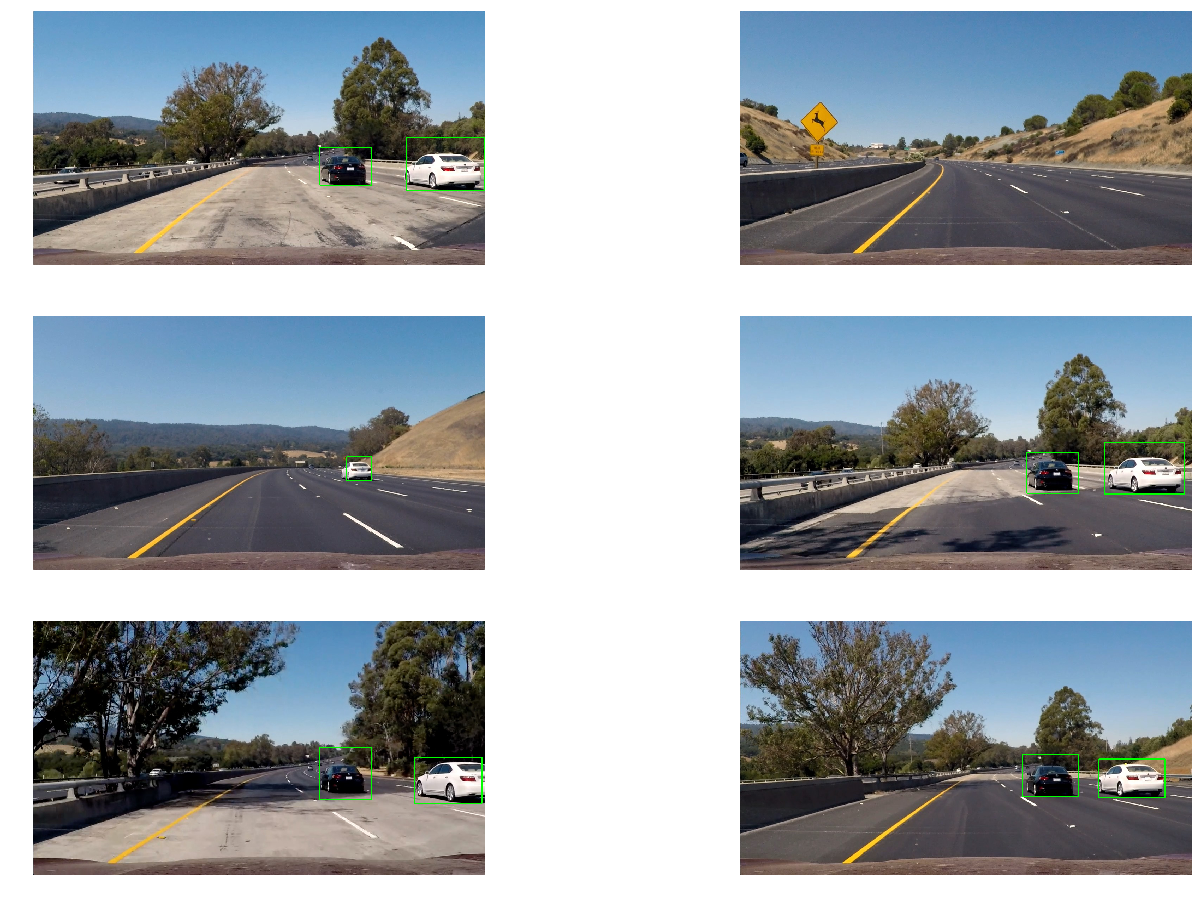

In [124]:
#Load Classifier & Scalar 
if __name__ == '__main__':
    with open('classifier.p', 'rb') as f:
        data = pickle.load(f)

    scaler = data['scaler']
    cls = data['classifier']

    test_images_dir = "test_images"
    output_images_dir = "output_images"
    
    #Search Window Dimensions
    window_size=[64, 80, 96, 112, 128, 160]#, 192, 224, 256]
    window_roi=[((200, 400),(1080, 550)), ((100, 400),(1180, 550)), ((0, 380),(1280, 550)),
                ((0, 360),(1280, 550)), ((0, 360),(1280, 600)), ((0, 360),(1280, 670)) ]#,

    video_files = ['test_video.mp4', 'project_video.mp4']
    output_path = "output_videos"

    def process_image(img, car_finder, reset = False):
        car_finder.find_cars(img, reset = reset)
        return car_finder.draw_cars(img)

    #Instantiate Class Finder
    cf = CarFinder(64, hist_bins=128, small_size=20, orientations=12, pix_per_cell=8, cell_per_block=1,
                       classifier=cls, scaler=scaler, window_sizes=window_size, window_rois=window_roi)

    i=0
    for img_path in os.listdir(test_images_dir):
        if "jpg" in img_path:
            img = mpimg.imread(os.path.join(test_images_dir, img_path))
            #Process Image
            res_img = process_image(img, cf, True)
            i+=1
            plt.subplot(3, 2, i)
            plt.imshow(res_img)
            plt.axis('off')
            #plt.show()
            mpimg.imsave(os.path.join(output_images_dir, img_path), res_img)
            
plt.subplots_adjust(left=0., right=3, top=3, bottom=0.)

# Test Pipeline on Video

In [30]:
for file in video_files:
    output = os.path.join(output_path,"cars_"+file)
    clip2 = VideoFileClip(file)
    challenge_clip = clip2.fl_image(lambda x: process_image(x, cf, True))
    print ("Akkii Generated", output, clip2)
    challenge_clip.write_videofile(output, audio=False)

Akkii Generated output_videos/cars_test_video.mp4 <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x11cf74b00>
[MoviePy] >>>> Building video output_videos/cars_test_video.mp4
[MoviePy] Writing video output_videos/cars_test_video.mp4


 97%|█████████▋| 38/39 [00:38<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/cars_test_video.mp4 

Akkii Generated output_videos/cars_project_video.mp4 <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x11cf744e0>
[MoviePy] >>>> Building video output_videos/cars_project_video.mp4
[MoviePy] Writing video output_videos/cars_project_video.mp4


100%|█████████▉| 1260/1261 [21:11<00:00,  1.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/cars_project_video.mp4 

